# Degradation Rates

$$ - \frac{dm}{dt} = k_d \rho SA$$

- $m$ is the mass
- $k_d$ is the specific surface degradation rate (SSDR)
- $\rho$ is the density
- $SA$ is the surface area

My main idea is to compute this rate from my fragmenting scheme, as a quantification of the degradation timescales.

How to compute the $SA$? 
Because the particles are squares: $$SA = 6L^2$$

Mass $m$ is 

$$m = \rho L^3$$

assuming that $\rho$ is a constant and discretizing the first equation:

$$- \frac{m_{i+1} - m_{i}}{dt} = k_d \rho SA_i$$

Me can compute $k_d$ for the data

$$k_d[i] = -\frac{1}{\rho dt} \frac{m[i+1] - m[i]}{SA[i]}$$


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from tqdm import tqdm

In [2]:
time_scales = [10] + [i for i in range(100, 600, 100)] + [1000, 10000]

In [3]:
for scale in time_scales:
    path = f'/storage/shared/oceanparcels/output_data/data_Claudio/set_19/set19_{scale}.zarr/'
    print(path)

/storage/shared/oceanparcels/output_data/data_Claudio/set_19/set19_10.zarr/
/storage/shared/oceanparcels/output_data/data_Claudio/set_19/set19_100.zarr/
/storage/shared/oceanparcels/output_data/data_Claudio/set_19/set19_200.zarr/
/storage/shared/oceanparcels/output_data/data_Claudio/set_19/set19_300.zarr/
/storage/shared/oceanparcels/output_data/data_Claudio/set_19/set19_400.zarr/
/storage/shared/oceanparcels/output_data/data_Claudio/set_19/set19_500.zarr/
/storage/shared/oceanparcels/output_data/data_Claudio/set_19/set19_1000.zarr/
/storage/shared/oceanparcels/output_data/data_Claudio/set_19/set19_10000.zarr/


In [5]:
ρ = 1380 #kg/m3
dt = 24*60*60

frag_stats = {}
for scale in tqdm(time_scales):
    path = f'/storage/shared/oceanparcels/output_data/data_Claudio/set_19/set19_{scale}.zarr/'
    aux_dict = {}
    
    sim = xr.open_zarr(path)
    sim = sim.compute()

    observations = sim.dims['obs']
    time = sim['time'][0,:]

    L  = sim['diameter'].values #np.ma.masked_greater(sim['diameter'].values, 1e-3)
    
    frag_time = np.nanargmin(abs(L - 1e-3), axis=1)
    frag_particles = np.where(frag_time != 0)[0]
    
#     frag_time = frag_time[frag_particles]
    
    L_mask = np.ma.masked_where(L > 1e-3, L)

    SA = np.ma.masked_where(L > 1e-3, 6*L**2)
    mass = np.ma.masked_where(L > 1e-3, ρ*L**3)
    mass_0 = mass[:, 0]
    mass_t = mass[:, frag_time]
    
    SA_t = SA[:, frag_time]
    
    aux_dict['median_length'] = np.median(L_mask.data, axis=0)
    aux_dict['mean_length'] = L_mask.mean(axis=0).data
    aux_dict['std_length'] = L_mask.std(axis=0).data

    sa = SA.mean(axis=0).data
    aux_dict['mean_SA'] = sa
    aux_dict['std_SA'] = SA.std(axis=0).data
    
    m = mass.mean(axis=0).data

    aux_dict['median_mass'] = np.median(mass.data, axis=0)
    aux_dict['mean_mass'] = m
    aux_dict['std_mass'] = mass.std(axis=0).data
    
    k_d_2 = (m - np.roll(m, -1))/(sa*dt*ρ) *1e6*3.15576e+7
    
    k_d = -(mass_t + mass_0)/(ρ*SA_t*frag_time) 
    
    aux_dict['k_d'] = np.nanmean(k_d)
    aux_dict['k_d_2'] = np.nanmean(k_d_2)
    
    aux_dict['k_d_std'] = np.nanstd(k_d)
    aux_dict['k_d_2_std'] = np.nanstd(k_d_2)
    
    frag_stats[scale] = aux_dict
    

100%|████████████████████████████████████████████████████████████████████████████| 8/8 [05:54<00:00, 44.28s/it]


$$k_d [\frac{\mu m}{year}]= \frac{m}{s} \  \frac{1e6 \mu m}{1 m } \ \frac{3.15576e+7 s}{1 year } \pm$$

In [6]:
convertion = 1e6*3.15576e+7

for scale in time_scales:
    print(scale, ': ', frag_stats[scale]['k_d']*convertion, '±', frag_stats[scale]['k_d_std']*convertion, '𝜇m/year')

10 :  -14945762.242231159 ± 27738771.804944955 𝜇m/year
100 :  -1478308.0950543645 ± 2809757.864147016 𝜇m/year
200 :  -733075.2237370281 ± 1422724.1262640085 𝜇m/year
300 :  -445068.19107416214 ± 908983.3561707024 𝜇m/year
400 :  -322875.1826536112 ± 682674.6141792636 𝜇m/year
500 :  -236814.6088260932 ± 537998.2272775304 𝜇m/year
1000 :  -76309.89274000925 ± 231703.4361993225 𝜇m/year
10000 :  -1139.0603091025644 ± 8037.179509901473 𝜇m/year


In [7]:
convertion = 1

for scale in time_scales:
    print(scale, ': ', frag_stats[scale]['k_d_2']*convertion, '±', frag_stats[scale]['k_d_2_std']*convertion, '𝜇m/year')

10 :  -14317.356447334416 ± 49619.10128697349 𝜇m/year
100 :  -17457.44646814041 ± 207700.815037309 𝜇m/year
200 :  -1008.3631081025832 ± 7085.82233838957 𝜇m/year
300 :  -2076.1545588103204 ± 28828.373991449105 𝜇m/year
400 :  -668.7764030654424 ± 7548.456457893963 𝜇m/year
500 :  -332.5478253629829 ± 2257.306466919402 𝜇m/year
1000 :  -128.52727319012055 ± 1309.0298391631372 𝜇m/year
10000 :  -31.0942180933871 ± 1434.7837102794385 𝜇m/year


Text(0, 0.5, 'Surface Area (m^2)')

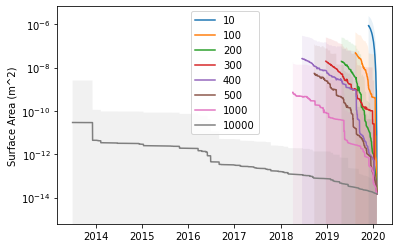

In [10]:
for scale in time_scales:
    y = frag_stats[scale]['mean_SA']
    y_err = frag_stats[scale]['std_SA']
    
    
    plt.fill_between(time, y - y_err, y + y_err, alpha=0.1)
    plt.plot(time, y, label=scale)
    
plt.semilogy()
plt.legend()
plt.ylabel('Surface Area (m^2)')

Text(0, 0.5, 'Lenght (m)')

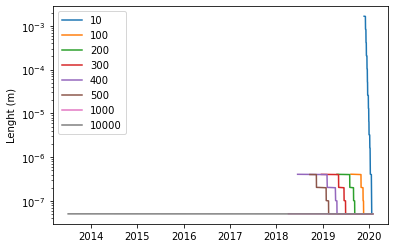

In [14]:
for scale in time_scales:
    y = frag_stats[scale]['median_length']
    y_err = frag_stats[scale]['std_length']
    
    
#     plt.fill_between(time, y - y_err, y + y_err, alpha=0.1)
    plt.plot(time, y, label=scale)
    
plt.semilogy()
plt.legend()
plt.ylabel('Lenght (m)')